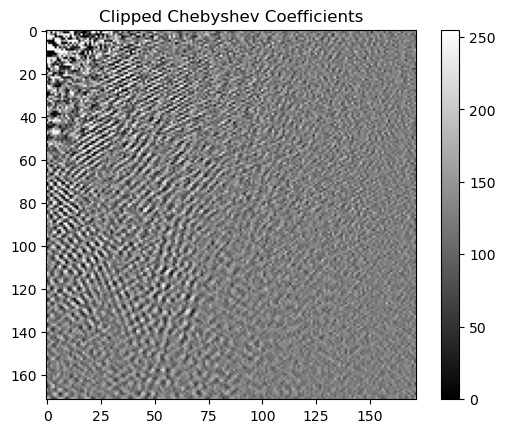

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def chebyshev_poly(n, x):
    """Compute the nth Chebyshev polynomial of the first kind evaluated at x."""
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return x
    else:
        T_prev = np.ones_like(x)
        T_curr = x
        for _ in range(2, n + 1):
            T_next = 2 * np.multiply(x, T_curr) - T_prev
            T_prev, T_curr = T_curr, T_next
        return T_curr


def discrete_chebyshev_transform_1d(sequence, n):
    """1D Discrete Chebyshev Transform."""
    N = len(sequence)
    coeff = 0
    for i in range(N):
        x = np.cos(np.pi * (i + 0.5) / N)
        coeff += sequence[i] * chebyshev_poly(n, x)
    return coeff

def discrete_chebyshev_transform_2d(image):
    h, w = image.shape
    coeffs = np.zeros((h, w), dtype=np.float32)
    
    # Compute the Chebyshev nodes for the entire image once
    x_values = np.cos(np.pi * (np.arange(h) + 0.5) / h)
    
    # Pre-compute the Chebyshev polynomial values for each n
    T_values = np.array([chebyshev_poly(n, x_values) for n in range(w)]).T  # shape (h, w)
    
    # Compute the row transforms for all rows and all n values using broadcasting
    row_transforms = (image[:, :, np.newaxis] * T_values[:, np.newaxis, :]).sum(axis=0)  # shape (h, w)
    
    for m in range(h):
        T_m_values = chebyshev_poly(m, x_values)
        coeffs[m] = (row_transforms * T_m_values[:, np.newaxis]).sum(axis=0)

    return coeffs

# Load the grayscale image
image = cv2.imread('input1.jpg', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Could not open the image. Ensure the path is correct.")

# Apply 2D Discrete Chebyshev Transform
coeffs = discrete_chebyshev_transform_2d(image)

# Clip the values to remove extreme outliers
coeffs_clipped = np.clip(coeffs, np.percentile(coeffs, 1), np.percentile(coeffs, 99))

# Normalize the clipped coefficients
coeffs_normalized = cv2.normalize(coeffs_clipped, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Display the normalized coefficients
plt.imshow(coeffs_normalized, cmap='gray')
plt.title("Clipped Chebyshev Coefficients")
plt.colorbar()
plt.show()

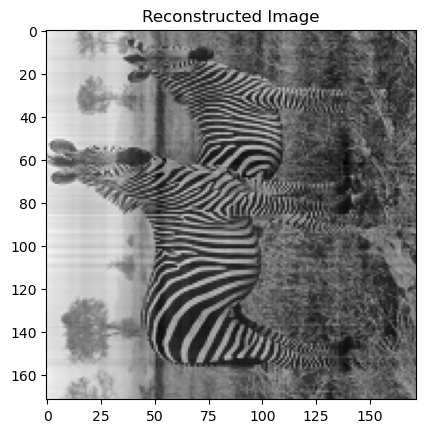

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# ... [The rest of your functions go here] ...

from numba import jit

@jit(nopython=True)
def chebyshev_poly_jit(n, x):
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return x
    T_prev = np.ones_like(x)
    T_curr = x
    for _ in range(2, n + 1):
        T_next = 2 * x * T_curr - T_prev
        T_prev, T_curr = T_curr, T_next
    return T_curr

@jit(nopython=True)
def inverse_discrete_chebyshev_transform_1d(coefficients, x):
    N = len(coefficients)
    sequence = np.zeros_like(x)
    for n in range(N):
        sequence += coefficients[n] * chebyshev_poly_jit(n, x)
    return sequence

def inverse_discrete_chebyshev_transform_2d(coeffs):
    h, w = coeffs.shape
    x_rows = np.cos(np.pi * (np.arange(h) + 0.5) / h)
    x_cols = np.cos(np.pi * (np.arange(w) + 0.5) / w)
    
    reconstructed_image = np.zeros((h, w), dtype=np.float32)
    
    # First, inverse transform the columns.
    for n in range(w):
        reconstructed_image[:, n] = inverse_discrete_chebyshev_transform_1d(coeffs[:, n], x_cols)
    
    # Then, inverse transform the resulting rows.
    temp_image = np.copy(reconstructed_image)
    for m in range(h):
        reconstructed_image[m, :] = inverse_discrete_chebyshev_transform_1d(temp_image[m, :], x_rows)
        
    return reconstructed_image





# ... [Load image, forward transform, display coefficients as before] ...

# Now let's get the inverse transform
reconstructed_image = inverse_discrete_chebyshev_transform_2d(coeffs)

# Display the reconstructed image
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.show()


<module 'matplotlib.pyplot' from 'c:\\Users\\umroot\\anaconda3\\envs\\tf\\lib\\site-packages\\matplotlib\\pyplot.py'>

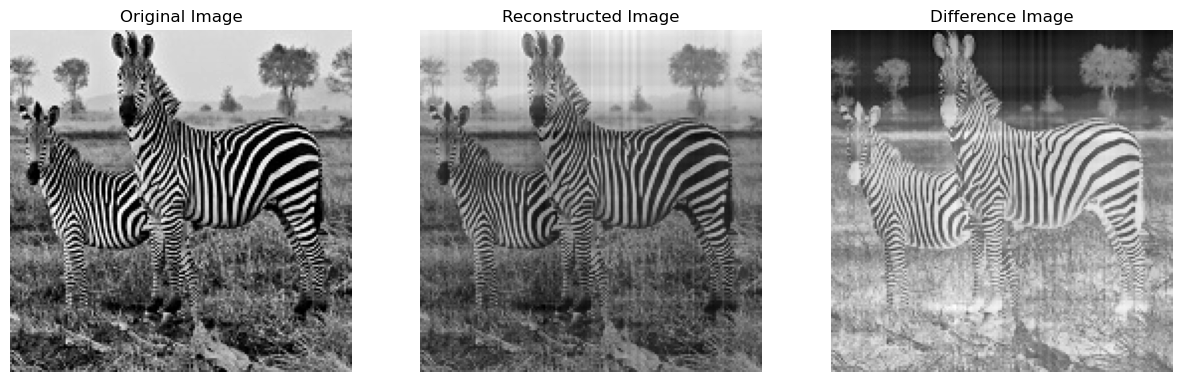

In [8]:
import matplotlib.pyplot as plt

# Assuming 'image' is the original image and 'reconstructed' is the inversed one
reconstructed_flipped = reconstructed_image[::-1, :]
difference = image.astype(np.float32) - np.rot90(reconstructed_flipped, -1).astype(np.float32)

# Normalize the difference for visualization purposes
difference_normalized = cv2.normalize(difference, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.figure(figsize=(15, 5))

# Original image
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Reconstructed image
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(reconstructed_flipped, -1), cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')

# Difference image
plt.subplot(1, 3, 3)
plt.imshow(difference_normalized, cmap='gray')
plt.title("Difference Image")
plt.axis('off')

plt
